# Sabina Hartnett: Classification Final

kNN performed consistently about as good as random coin toss.
Naive Bayes and Logistic Regression/PCA performed consistently the best
Neural Networks and SVMs also performed quite well, with NN generally performing better.

So this notebook trains and evaluates Logistic Regression and PCA analysis, Naive Bayes Classification and Multilayer Perceptron Neural Network Classification on the full dataset as well as specified subsets in order to test the performance of these classifiers and the ability of unseen subsets of this dataset to be accurately classified.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [2]:
p_tweetsDF = pandas.read_csv('Data/cleaned_tokenized.csv', index_col=False)
#p_tweetsDF = pandas.read_csv('Data/cleaned_tweets.csv', index_col=False)
#p_tweetsDF = p_tweetsDF1.sample(frac = 0.1)

In [3]:
results_df = pandas.DataFrame(columns =['Model', 'Data', 'TestError'])

In [4]:
results_df.head()

,Model,Data,TestError


In [5]:
#results_df = results_df.append({'Model': 'string', 'Data': 'another string', 'TestError':2}, ignore_index = True)

In [6]:
#print(results_df)

In [7]:
#only need to do this on first run
#p_tweetsDF['tokenized_text'] = p_tweetsDF['clean_text'].apply(lambda x: lucem_illud.word_tokenize(x))
#p_tweetsDF['normalized_text'] = p_tweetsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [8]:
#p_tweetsDF.to_csv('Data/cleaned_tokenized.csv')

## Analysts:
Architect (INTJ), Logician (INTP), Commander (ENTJ), Debater (ENTP)
--> ..'NT'..

## Diplomats
Advocate (INFJ), Mediator (INFP), Protagonist (ENFJ), Campaigner (ENFP)
--> ..'NF'..
## Sentinels
Logistician (ISTJ), Defender (ISFJ), Executive (ESTJ), Consul (ESFJ)
--> ..'S'..'J'
## Explorers
Virtuoso (ISTP), Adventurer (ISFP), Entrepreneur (ESTP), Entertainer (ESFP)
--> ..'S'..'P'

As we can see above, according to the 16 personality types theory, Intuitive vs Observant is the most important factor in determining someones' personality group type

In [9]:
def categorize(df, attribute):
    
    df['category'] = [(categ == 1) for categ in df[attribute]]
    
    return df

In [10]:
extravert_df = categorize(p_tweetsDF, 'extravert')
intuitive_df = categorize(p_tweetsDF, 'intuitive')
judging_df = categorize(p_tweetsDF, 'judging')
thinking_df = categorize(p_tweetsDF, 'thinking')

analyst = 'NT'
diplomat = 'NF'
sentinel = 'SJ'
explorer = 'SP'

analyst_df = categorize(p_tweetsDF, 'NT')
diplomat_df = categorize(p_tweetsDF, 'NF')
sentinel_df = categorize(p_tweetsDF, 'SJ')
explorer_df = categorize(p_tweetsDF, 'SP')

SF_df = categorize(p_tweetsDF, 'SF')
ST_df = categorize(p_tweetsDF, 'ST')
NJ_df = categorize(p_tweetsDF, 'NJ')
NP_df = categorize(p_tweetsDF, 'NP')

In [11]:
#mask1 = SF_df.loc[:, 'extravert'] == 1

In [12]:
def sample_combo_df(df, attribute1, attribute2, num_obs, test_frac):
    '''
    '''
    if attribute2 == 'not':
        attribute2 = attribute1
        matching2 = 0
    else:
        matching2 = 1
    
    mask1 = df.loc[:, attribute1] == 1
    df1 = df[mask1].sample(num_obs)
    df1Train, df1Test = lucem_illud.trainTestSplit(df1, holdBackFraction =test_frac)
    
    mask2 = df.loc[:, attribute2] == matching2
    df2 = df[mask2].sample(num_obs)
    df2Train, df2Test = lucem_illud.trainTestSplit(df2, holdBackFraction =test_frac)
    
    train_data = df1Train.append(df2Train, ignore_index =True)
    test_data = df1Test.append(df2Test, ignore_index =True)
    
    return train_data, test_data

In [13]:
#dftest1, dftest2 = sample_combo_df(p_tweetsDF, 'extravert', 'intuitive', 10, 0.1)

In [14]:
#dftest1

In [15]:
def naive_bayes(train_df, test_df):
    
    
    naiveBayes = sklearn.naive_bayes.BernoulliNB()
    naiveBayes.fit(np.stack(train_df['vect'], axis=0), train_df['category'])
    training_err = naiveBayes.score(np.stack(train_df['vect'], axis=0), train_df['category'])
    testing_err = naiveBayes.score(np.stack(test_df['vect'], axis=0), test_df['category'])
    print("training error:", training_err)
    print("testing error:", testing_err)
    
    return (training_err, testing_err)

In [16]:
def SVM(combinedDF, test_frac=0.1):
    '''linear kernel SVM
    note: needs to take a DF with a category'''
    combinedDF = combinedDF.sample(100)
    
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
    clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
    
    TFVects = TFVectorizer.fit_transform([' '.join(l) for l in combinedDF['normalized_text']])
    combinedDF['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
    
    trainDF, testDF = lucem_illud.trainTestSplit(combinedDF, holdBackFraction=test_frac)
    
    clf_svm.fit(np.stack(trainDF['vect'], axis=0), trainDF['category'])
    
    evaluate = lucem_illud.evaluateClassifier(clf_svm, testDF)
    lucem_illud.plotConfusionMatrix(clf_svm, testDF)
    
    return evaluate
    

In [17]:
def NeuralNet(train_DF, test_DF):
    '''MLP'''
    clf_nn = sklearn.neural_network.MLPClassifier()
    clf_nn.fit(np.stack(train_DF['vect'], axis=0), train_DF['category'])
    evaluate = lucem_illud.evaluateClassifier(clf_nn, test_DF)
    
    lucem_illud.plotConfusionMatrix(clf_nn, test_DF)
    
    return evaluate

In [18]:
#can be run with naive bayes,
def train_test_clf(df, attribute, model, holdBackFraction =0.1):
    '''
    '''
    
    dfTrain, dfTest = lucem_illud.trainTestSplit(df, holdBackFraction=holdBackFraction)
    
    model.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    np.stack(dfTrain['vect'])
    evaluation = lucem_illud.evaluateClassifier(model, dfTest)
    lucem_illud.plotConfusionMatrix(clf, dfTest)
    lucem_illud.plotMultiROC(clf, dfTest)
    
    return evaluation

In [19]:
def logit_reg_PCA(dfTrain, dfTest):
    '''
    '''
    
    logistic = sklearn.linear_model.LogisticRegression()
    
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(dfTrain['clean_text'])
    #TFVects is a sparse matrix, so we'll make a dense matrix
    dfTrain['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
    pca = sklearn.decomposition.PCA()
    reduced_data = pca.fit_transform(np.stack(dfTrain['vect'], axis=0))
    dfTrain['pca'] = [r for r in reduced_data]
    
    #Create vectors
    TFVects_test = TFVectorizer.transform(dfTest['clean_text'])
    dfTest['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

    #PCA
    reduced_data_test = pca.transform(np.stack(dfTest['vect'], axis=0))
    dfTest['pca'] = [r for r in reduced_data_test]
    
    testing_scores = []
    training_scores = []
    for PCA in range(1,len(dfTrain)):
        str_col = 'pca_reduct_' + str(PCA)
        dfTrain[str_col] = dfTrain['pca'].apply(lambda x: x[:PCA])
        dfTest[str_col] = dfTest['pca'].apply(lambda x: x[:PCA])

        logistic.fit(np.stack(dfTrain[str_col], axis=0), dfTrain['category'])

        training_scores.append(logistic.score(np.stack(dfTrain[str_col], axis=0), dfTrain['category']))
        testing_scores.append(logistic.score(np.stack(dfTest[str_col], axis=0), dfTest['category']))
    
    PCA_train_test = pandas.DataFrame({'training:': training_scores, 'testing': testing_scores})
    PCA_train_test.plot.line()


In [20]:
extravert_df.head()
#t_err, tst_err = naive_bayes(extravert_df)


,Unnamed: 0,Unnamed: 0.1,liked_by,text,type,extravert,intuitive,thinking,judging,NT,...,ST,NJ,NP,SJ,SP,foreign_frac,clean_text,tokenized_text,normalized_text,category
0,0,0,1271680686576058368,just found out someone confessed /r feelings t...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.3094,just found out someone confessed /r feelings t...,"['just', 'found', 'out', 'someone', 'confessed...","['find', 'confess', '/r', 'feeling', 'oliver',...",False
1,1,1,14283777,Wait. Who called him the “Italian Stallion”???...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.2267,Wait. Who called him the “Italian Stallion”???...,"['Wait', 'Who', 'called', 'him', 'the', 'Itali...","['wait', 'call', 'italian', 'stallion', 'grate...",False
2,2,5,956641603384377346,"""This is like two of my Uncles fighting at the...",ESTP,1,0,1,0,0,...,1,0,0,0,1,0.2888,"""This is like two of my Uncles fighting at the...","['This', 'is', 'like', 'two', 'of', 'my', 'Unc...","['like', 'uncle', 'fight', 'bbq', 'tysonvsjone...",False
3,3,6,975396348504821766,ur welcome https://t.co/e2KF57KLxbI'm losing m...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.3575,ur welcome losing my fucking mind : mfs with c...,"['ur', 'welcome', 'losing', 'my', 'fucking', '...","['ur', 'welcome', 'lose', 'fuck', 'mind', 'mfs...",False
4,4,7,1053019674600976385,https://t.co/DFf1NhbRq5If You’re Too Shy (Let ...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.4863,You’re Too Shy (Let Me Know) by The 1975 2017 ...,"['You', '’re', 'Too', 'Shy', 'Let', 'Me', 'Kno...","['shy', 'let', 'know', 'kiss', 'long', 'eye', ...",False


## Extraverts vs. Introverts
using the full dataset

In [21]:
num_obs = 500
test_frac = 0.1

In [22]:
extravert_df500 = extravert_df.sample(500)

In [23]:
extvert_dfTrain, exvert_dfTest = lucem_illud.trainTestSplit(extravert_df500, holdBackFraction =0.1)

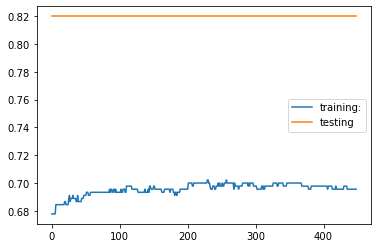

In [24]:
logit_reg_PCA(extvert_dfTrain, exvert_dfTest)

In [25]:
extr_NB = naive_bayes(extvert_dfTrain, exvert_dfTest)

training error: 0.9333333333333333
testing error: 0.82


In [26]:
extr_NB[1] #testing error

0.82

In [27]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Intro vs Extraverts', 'TestError': 1-extr_NB[1]}, ignore_index = True)

In [28]:
extravert_df500['normalized_text']

1870    ['writer', 'block', 'wrong', 'obsess', 'w', 'o...
1877    ['gnight', 'way', 'tomorrow', 'tomorrow', 'tom...
2939    ['million', 'people', 'texas', 'electricity', ...
1680    ['be', 'finally', 'eat', 'inside', 'yasssssss'...
2919    ['reminder', 'senate', 'week', 'go', 'work', '...
                              ...                        
1762    ['wait', 'apple', 'car', 'mir', 'haben', 'die'...
306     ['r', 'u', 'gon', 'na', 'bed', 'plushiesheartw...
583     ['hand', 'cat', 'human', 'filter', 'fulfill', ...
913     ['worldcancerday', 'think', 'little', 'bean', ...
3232    ['quack', 'round', 'nigga', 'fuck', 'coocooo',...
Name: normalized_text, Length: 500, dtype: object

In [29]:
#extraSVMeval = SVM(extravert_df500, test_frac)

In [30]:
#print(extraSVMeval)

In [31]:
#ex_avSVM_err = (extraSVMeval['Error_Rate'][0] + extraSVMeval['Error_Rate'][1])/2
#results_df = results_df.append({'Model': 'SVM', 'Data': 'Full Set Intro vs Extraverts', 'TestError': 1-ex_avSVM_err}, ignore_index = True)

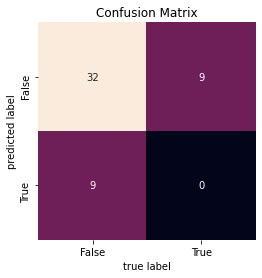

In [32]:
extraNNeval = NeuralNet(extvert_dfTrain, exvert_dfTest)

In [33]:
print(extraNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.36  0.390244   0.780488           0.789161  0.780488
True            0.36  0.390244   0.000000           0.180000  0.000000


In [34]:
ex_avNN_err = (extraNNeval['Error_Rate'][0] + extraNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Intro vs Extraverts', 'TestError': ex_avNN_err}, ignore_index = True)

## Intuitive vs. Observant
using the full dataset

In [35]:
intuitive_df500 = intuitive_df.sample(500)

In [36]:
N_dfTrain, N_dfTest = lucem_illud.trainTestSplit(intuitive_df500, holdBackFraction =0.1)

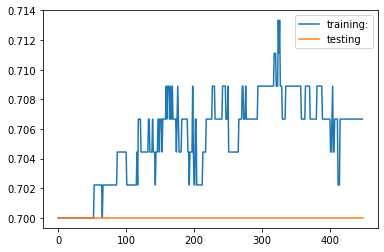

In [37]:
logit_reg_PCA(N_dfTrain, N_dfTest)

In [38]:
intuitNB = naive_bayes(N_dfTrain, N_dfTest)

training error: 0.9622222222222222
testing error: 0.68


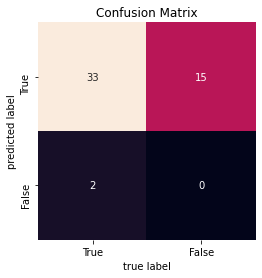

In [39]:
intuitNNeval = NeuralNet(N_dfTrain, N_dfTest)

In [40]:
print(intuitNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.34  0.471429     0.6875           0.688214  0.942857
True            0.34  0.471429     0.0000           0.300000  0.000000


In [41]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Intuitive vs Observant', 'TestError': 1-intuitNB[1]}, ignore_index = True)
intuit_avNN_err = (intuitNNeval['Error_Rate'][0] + intuitNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Intuitive vs Observant', 'TestError': intuit_avNN_err}, ignore_index = True)

## Judging vs. Prospecting
using the full dataset

In [42]:
judging_df500 = judging_df.sample(500)

In [43]:
J_dfTrain, J_dfTest = lucem_illud.trainTestSplit(judging_df500, holdBackFraction =0.1)

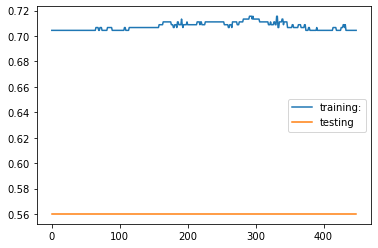

In [44]:
logit_reg_PCA(J_dfTrain, J_dfTest)

In [45]:
judgNB = naive_bayes(J_dfTrain, J_dfTest)

training error: 0.9755555555555555
testing error: 0.56


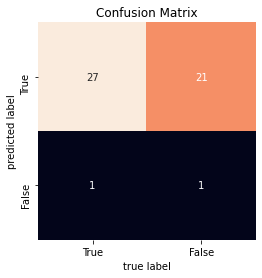

In [46]:
judgNNeval = NeuralNet(J_dfTrain, J_dfTest)

In [47]:
print(judgNNeval)

          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
False           0.44  0.50487     0.5625           0.562411  0.964286
True            0.44  0.50487     0.5000           0.442727  0.045455


In [48]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Judging vs Prospecting', 'TestError': 1-judgNB[1]}, ignore_index = True)
j_avNN_err = (judgNNeval['Error_Rate'][0] + judgNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Judging vs Prospecting', 'TestError': j_avNN_err}, ignore_index = True)

## Thinking vs. Feeling
using the full dataset

In [49]:
thinking_df500 = intuitive_df.sample(500)

In [50]:
T_dfTrain, T_dfTest = lucem_illud.trainTestSplit(thinking_df500, holdBackFraction =0.1)

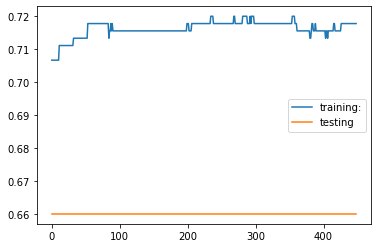

In [51]:
logit_reg_PCA(T_dfTrain, T_dfTest)

In [52]:
thinkNB = naive_bayes(T_dfTrain, T_dfTest)

training error: 0.9644444444444444
testing error: 0.62


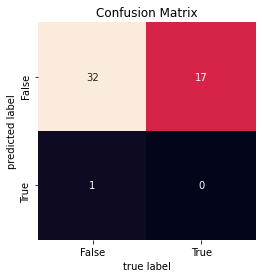

In [53]:
thinkNNeval = NeuralNet(T_dfTrain, T_dfTest)

In [54]:
print(thinkNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.36  0.484848   0.653061           0.653271  0.969697
True            0.36  0.484848   0.000000           0.340000  0.000000


In [55]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Thinking vs Feeling', 'TestError': 1-thinkNB[1]}, ignore_index = True)
t_avNN_err = (thinkNNeval['Error_Rate'][0] + thinkNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Thinking vs Feeling', 'TestError': t_avNN_err}, ignore_index = True)

## Analyst vs. Else
using the full dataset

In [56]:
analyst_df500 = analyst_df.sample(500)

In [57]:
NT_dfTrain, NT_dfTest = lucem_illud.trainTestSplit(analyst_df500, holdBackFraction =0.1)

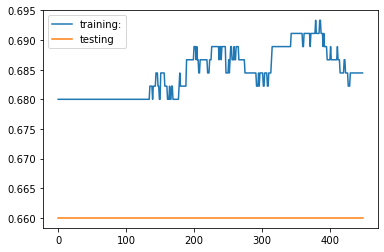

In [58]:
logit_reg_PCA(NT_dfTrain, NT_dfTest)

In [59]:
anlstNB = naive_bayes(NT_dfTrain, NT_dfTest)

training error: 0.9511111111111111
testing error: 0.66


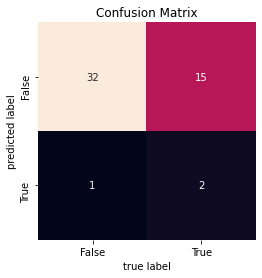

In [60]:
anlstNNeval = NeuralNet(NT_dfTrain, NT_dfTest)

In [61]:
print(anlstNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.32  0.543672   0.680851           0.680219  0.969697
True            0.32  0.543672   0.666667           0.378431  0.117647


In [62]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Analyst vs Else', 'TestError': 1-anlstNB[1]}, ignore_index = True)
anlst_avNN_err = (anlstNNeval['Error_Rate'][0] + anlstNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Analyst vs Else', 'TestError': anlst_avNN_err}, ignore_index = True)

## Diplomat vs. Else
using the full dataset

In [63]:
diplomat_df500 = diplomat_df.sample(500)

In [64]:
NF_dfTrain, NF_dfTest = lucem_illud.trainTestSplit(diplomat_df500, holdBackFraction =0.1)

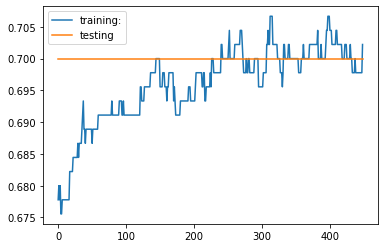

In [65]:
logit_reg_PCA(NF_dfTrain, NF_dfTest)

In [66]:
dipNB = naive_bayes(NF_dfTrain, NF_dfTest)

training error: 0.9622222222222222
testing error: 0.68


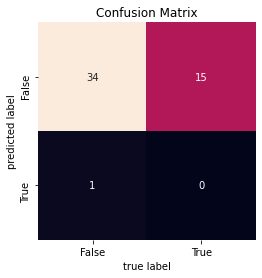

In [67]:
dipNNeval = NeuralNet(NF_dfTrain, NF_dfTest)

In [68]:
print(dipNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.32  0.485714   0.693878           0.694052  0.971429
True            0.32  0.485714   0.000000           0.300000  0.000000


In [69]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Diplomat vs Else', 'TestError': 1-dipNB[1]}, ignore_index = True)
dip_avNN_err = (dipNNeval['Error_Rate'][0] + dipNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Diplomat vs Else', 'TestError': dip_avNN_err}, ignore_index = True)

## Sentinel vs. Else
using the full dataset

In [70]:
sentinel_df500 = sentinel_df.sample(500)

In [71]:
SJ_dfTrain, SJ_dfTest = lucem_illud.trainTestSplit(sentinel_df500, holdBackFraction =0.1)

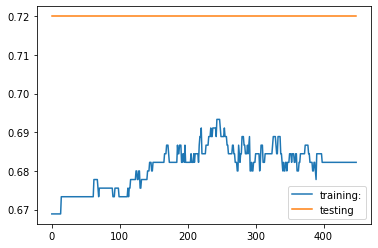

In [72]:
logit_reg_PCA(SJ_dfTrain, SJ_dfTest)

In [73]:
sentNB = naive_bayes(SJ_dfTrain, SJ_dfTest)

training error: 0.9711111111111111
testing error: 0.7


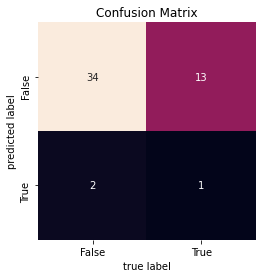

In [74]:
sentNNeval = NeuralNet(SJ_dfTrain, SJ_dfTest)

In [75]:
print(sentNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False            0.3  0.507937   0.723404           0.723215  0.944444
True             0.3  0.507937   0.333333           0.283810  0.071429


In [76]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Sentinel vs Else', 'TestError': 1-sentNB[1]}, ignore_index = True)
sent_avNN_err = (sentNNeval['Error_Rate'][0] + sentNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Sentinel vs Else', 'TestError': sent_avNN_err}, ignore_index = True)

## Explorer vs. Else
using the full dataset

In [77]:
explorer_df500 = explorer_df.sample(500)

In [78]:
SP_dfTrain, SP_dfTest = lucem_illud.trainTestSplit(explorer_df500, holdBackFraction =0.1)

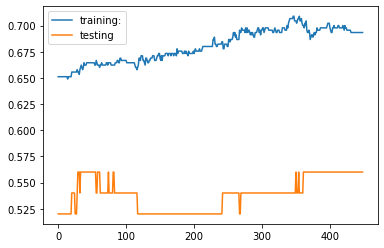

In [79]:
logit_reg_PCA(SP_dfTrain, SP_dfTest)

In [80]:
explNB = naive_bayes(SP_dfTrain, SP_dfTest)

training error: 0.9711111111111111
testing error: 0.56


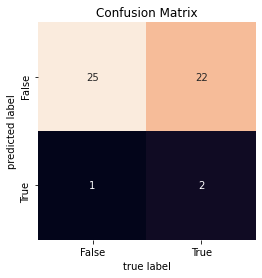

In [81]:
explNNeval = NeuralNet(SP_dfTrain, SP_dfTest)

In [82]:
print(explNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.46  0.522436   0.531915           0.531457  0.961538
True            0.46  0.522436   0.666667           0.495556  0.083333


In [83]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Explorer vs Else', 'TestError': 1-explNB[1]}, ignore_index = True)
expl_avNN_err = (explNNeval['Error_Rate'][0] + explNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Explorer vs Else', 'TestError': expl_avNN_err}, ignore_index = True)

## Using Subsets to Test Classifications

In [84]:
num_obs = 500
test_frac = 0.1
#500 is both computationally feasible and reasonably representative

## Introvert vs. Extravert
using subset of dataset (num_obs for each)

In [86]:
extravert = 'extravert'

In [87]:
int_ext_dfTrain, int_ext_dfTest = sample_combo_df(p_tweetsDF, extravert, 'not', num_obs, test_frac)

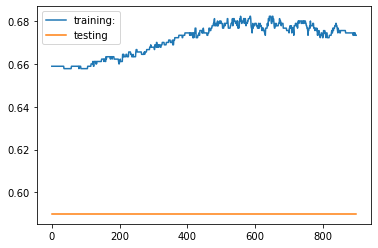

In [88]:
logit_reg_PCA(int_ext_dfTrain, int_ext_dfTest)

In [89]:
intexNB = naive_bayes(int_ext_dfTrain, int_ext_dfTest)

training error: 0.96
testing error: 0.57


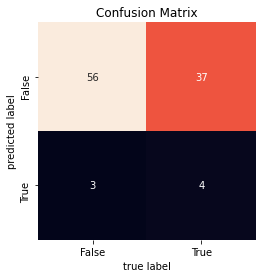

In [90]:
intexNNeval = NeuralNet(int_ext_dfTrain, int_ext_dfTest)

In [91]:
print(intexNNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False            0.4  0.523357   0.602151           0.601533  0.949153
True             0.4  0.523357   0.571429           0.425749  0.097561


In [93]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Introvert vs Extravert', 'TestError': 1-intexNB[1]}, ignore_index = True)
intex_avNN_err = (intexNNeval['Error_Rate'][0] + intexNNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Introvert vs Extravert', 'TestError': intex_avNN_err}, ignore_index = True)

## Intuitive vs. Observant
using subset of dataset (num_obs for each)

In [94]:
intuitive = 'intuitive'

In [95]:
int_obs_dfTrain, int_obs_dfTest = sample_combo_df(p_tweetsDF, intuitive, 'not', num_obs, test_frac)

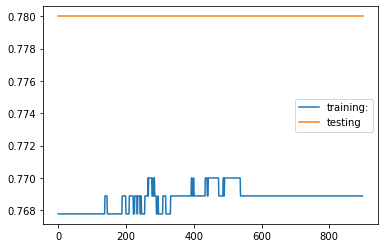

In [96]:
logit_reg_PCA(int_obs_dfTrain, int_obs_dfTest)

In [97]:
intobsNB = naive_bayes(int_obs_dfTrain, int_obs_dfTest)

training error: 0.9288888888888889
testing error: 0.77


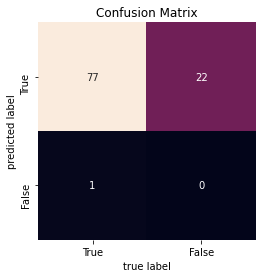

In [98]:
int_obs_NNeval = NeuralNet(int_obs_dfTrain, int_obs_dfTest)

In [99]:
print(int_obs_NNeval)

          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
False           0.23  0.49359   0.777778           0.777806  0.987179
True            0.23  0.49359   0.000000           0.220000  0.000000


In [100]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Intuitive vs Observant', 'TestError': 1-intobsNB[1]}, ignore_index = True)
intobs_avNN_err = (int_obs_NNeval['Error_Rate'][0] + int_obs_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Intuitive vs Observant', 'TestError': intobs_avNN_err}, ignore_index = True)

## Judging vs. Prospecting
using subset of dataset (num_obs for each)

In [101]:
judging = 'judging'

In [102]:
judg_pros_dfTrain, judg_pros_dfTest = sample_combo_df(p_tweetsDF, judging, 'not', num_obs, test_frac)

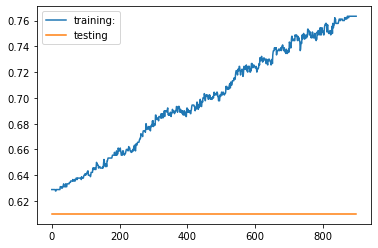

In [103]:
logit_reg_PCA(judg_pros_dfTrain, judg_pros_dfTest)

In [104]:
jug_prosNB = naive_bayes(judg_pros_dfTrain, judg_pros_dfTest)

training error: 0.97
testing error: 0.63


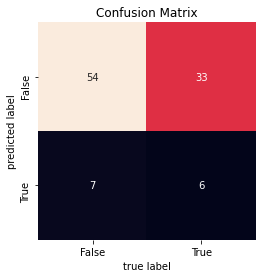

In [105]:
judg_pros_NNeval = NeuralNet(judg_pros_dfTrain, judg_pros_dfTest)

In [106]:
print(judg_pros_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False            0.4  0.519546   0.620690           0.619463  0.885246
True             0.4  0.519546   0.461538           0.401006  0.153846


In [107]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Judging vs Prospecting', 'TestError': 1-jug_prosNB[1]}, ignore_index = True)
jug_pros_avNN_err = (judg_pros_NNeval['Error_Rate'][0] + judg_pros_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Judging vs Prospecting', 'TestError': jug_pros_avNN_err}, ignore_index = True)

## Thinking vs. Feeling
using subset of dataset (num_obs for each)

In [108]:
thinking = 'thinking'

In [109]:
thi_feel_dfTrain, thi_feel_dfTest = sample_combo_df(p_tweetsDF, thinking, 'not', num_obs, test_frac)

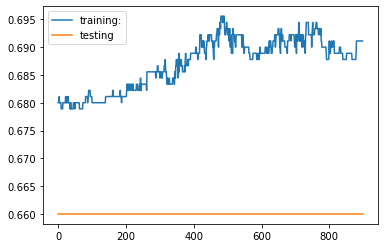

In [110]:
logit_reg_PCA(thi_feel_dfTrain, thi_feel_dfTest)

In [111]:
think_feelNB = naive_bayes(thi_feel_dfTrain, thi_feel_dfTest)

training error: 0.9666666666666667
testing error: 0.67


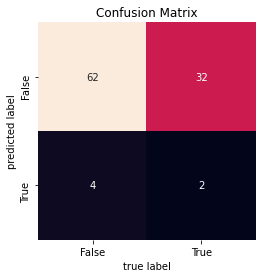

In [112]:
thi_feel_NNeval = NeuralNet(thi_feel_dfTrain, thi_feel_dfTest)

In [113]:
print(thi_feel_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.36  0.499109   0.659574           0.659600  0.939394
True            0.36  0.499109   0.333333           0.339608  0.058824


In [114]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Thinking vs Feeling', 'TestError': 1-think_feelNB[1]}, ignore_index = True)
thi_feel_avNN_err = (thi_feel_NNeval['Error_Rate'][0] + thi_feel_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Thinking vs Feeling', 'TestError': thi_feel_avNN_err}, ignore_index = True)

## Exploring direct comparisons between groupings

## Analyst vs. Diplomat
using subset of dataset (num_obs for each)

In [115]:
an_dip_dfTrain, an_dip_dfTest = sample_combo_df(analyst_df, analyst, diplomat, num_obs, test_frac)

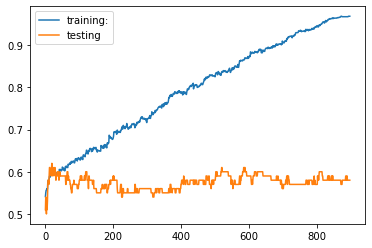

In [116]:
logit_reg_PCA(an_dip_dfTrain, an_dip_dfTest)

In [117]:
an_dipNB = naive_bayes(an_dip_dfTrain, an_dip_dfTest)

training error: 0.9855555555555555
testing error: 0.55


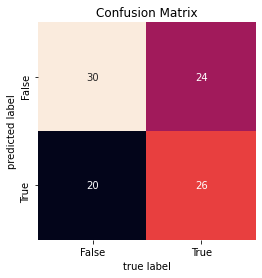

In [118]:
an_dip_NNeval = NeuralNet(an_dip_dfTrain, an_dip_dfTest)

In [119]:
print(an_dip_NNeval)

          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
False           0.44  0.56   0.555556           0.533333    0.60
True            0.44  0.56   0.565217           0.533913    0.52


In [120]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Analyst vs Diplomat', 'TestError': 1-an_dipNB[1]}, ignore_index = True)
an_dipavNN_err = (an_dip_NNeval['Error_Rate'][0] + an_dip_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Analyst vs Diplomat', 'TestError': an_dipavNN_err}, ignore_index = True)

## Analyst vs. Sentinel
using subset of dataset (num_obs for each)

In [121]:
an_sent_dfTrain, an_sent_dfTest = sample_combo_df(analyst_df, analyst, sentinel, num_obs, test_frac)

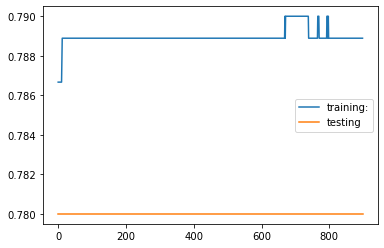

In [122]:
logit_reg_PCA(an_sent_dfTrain, an_sent_dfTest)

In [123]:
an_sentNB = naive_bayes(an_sent_dfTrain, an_sent_dfTest)

training error: 0.9211111111111111
testing error: 0.78


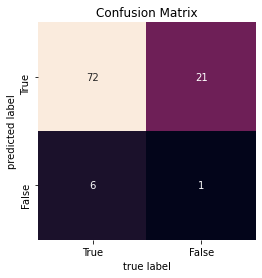

In [124]:
an_sent_NNeval = NeuralNet(an_sent_dfTrain, an_sent_dfTest)

In [125]:
print(an_sent_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.27  0.484266   0.774194           0.774640  0.923077
True            0.27  0.484266   0.142857           0.216494  0.045455


In [126]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Analyst vs Sentinel', 'TestError': 1-an_sentNB[1]}, ignore_index = True)
an_sent_avNN_err = (an_sent_NNeval['Error_Rate'][0] + an_sent_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Analyst vs Sentinel', 'TestError': an_sent_avNN_err}, ignore_index = True)

## Analyst vs. Explorer
using subset of dataset (num_obs for each)

In [146]:
an_expl_dfTrain, an_expl_dfTest = sample_combo_df(analyst_df, analyst, explorer, 350, test_frac)

note here: size of samples is different due to an issue in the data representation

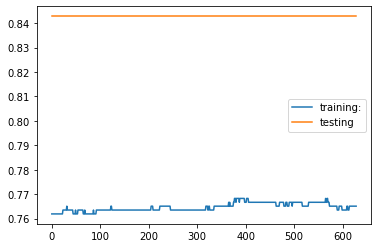

In [150]:
logit_reg_PCA(an_expl_dfTrain, an_expl_dfTest)

In [151]:
an_explNB = naive_bayes(an_expl_dfTrain, an_expl_dfTest)

training error: 0.9142857142857143
testing error: 0.7857142857142857


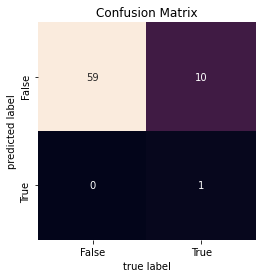

In [152]:
an_expl_NNeval = NeuralNet(an_expl_dfTrain, an_expl_dfTest)

In [153]:
print(an_expl_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.142857  0.545455   0.855072           0.855072  1.000000
True        0.142857  0.545455   1.000000           0.233766  0.090909


In [154]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Analyst vs Explorer', 'TestError': 1-an_explNB[1]}, ignore_index = True)
an_expl_avNN_err = (an_expl_NNeval['Error_Rate'][0] + an_expl_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Analyst vs Explorer', 'TestError': an_expl_avNN_err}, ignore_index = True)

## Diplomat vs. Sentinel
using subset of dataset (num_obs for each)

In [155]:
dip_sent_dfTrain, dip_sent_dfTest = sample_combo_df(diplomat_df, diplomat, sentinel, num_obs, test_frac)

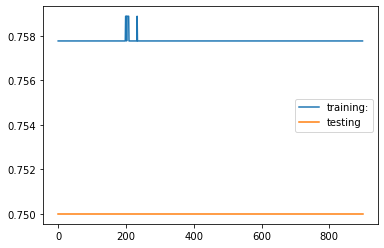

In [156]:
logit_reg_PCA(dip_sent_dfTrain, dip_sent_dfTest)

In [157]:
dip_sentNB = naive_bayes(dip_sent_dfTrain, dip_sent_dfTest)

training error: 0.9522222222222222
testing error: 0.74


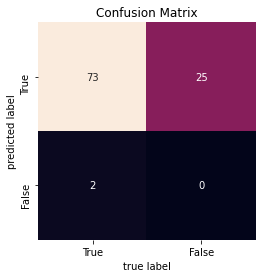

In [158]:
dip_sent_NNeval = NeuralNet(dip_sent_dfTrain, dip_sent_dfTest)

In [159]:
print(dip_sent_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.27  0.486667   0.744898           0.745034  0.973333
True            0.27  0.486667   0.000000           0.250000  0.000000


In [160]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Diplomat vs Sentinel', 'TestError': 1-dip_sentNB[1]}, ignore_index = True)
dip_sent_avNN_err = (dip_sent_NNeval['Error_Rate'][0] + dip_sent_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Diplomat vs Sentinel', 'TestError': dip_sent_avNN_err}, ignore_index = True)

## Diplomat vs. Explorer
using subset of dataset (num_obs for each)

In [175]:
dip_expl_dfTrain, dip_expl_dfTest = sample_combo_df(diplomat_df, diplomat, explorer, 350, test_frac)

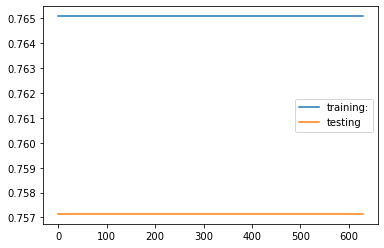

In [176]:
logit_reg_PCA(dip_expl_dfTrain, dip_expl_dfTest)

In [177]:
dip_explNB = naive_bayes(dip_expl_dfTrain, dip_expl_dfTest)

training error: 0.9285714285714286
testing error: 0.7428571428571429


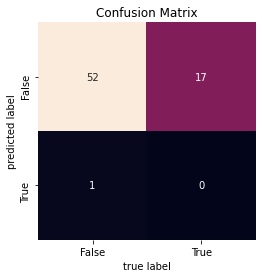

In [178]:
dip_expl_NNeval = NeuralNet(dip_expl_dfTrain, dip_expl_dfTest)

In [179]:
print(dip_expl_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False       0.257143  0.490566   0.753623           0.753690  0.981132
True        0.257143  0.490566   0.000000           0.242857  0.000000


In [167]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Diplomat vs Explorer', 'TestError': 1-dip_explNB[1]}, ignore_index = True)
dip_expl_avNN_err = (dip_expl_NNeval['Error_Rate'][0] + dip_expl_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Diplomat vs Explorer', 'TestError': dip_expl_avNN_err}, ignore_index = True)

## Sentinel vs. Explorer
using subset of dataset (num_obs for each)

In [183]:
sent_expl_dfTrain, sent_expl_dfTest = sample_combo_df(sentinel_df, sentinel, explorer, 350, test_frac)

In [186]:
#logit_reg_PCA(sent_expl_dfTrain, sent_expl_dfTest)
sentinel_df.head()

,Unnamed: 0,Unnamed: 0.1,liked_by,text,type,extravert,intuitive,thinking,judging,NT,...,ST,NJ,NP,SJ,SP,foreign_frac,clean_text,tokenized_text,normalized_text,category
0,0,0,1271680686576058368,just found out someone confessed /r feelings t...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.3094,just found out someone confessed /r feelings t...,"['just', 'found', 'out', 'someone', 'confessed...","['find', 'confess', '/r', 'feeling', 'oliver',...",False
1,1,1,14283777,Wait. Who called him the “Italian Stallion”???...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.2267,Wait. Who called him the “Italian Stallion”???...,"['Wait', 'Who', 'called', 'him', 'the', 'Itali...","['wait', 'call', 'italian', 'stallion', 'grate...",False
2,2,5,956641603384377346,"""This is like two of my Uncles fighting at the...",ESTP,1,0,1,0,0,...,1,0,0,0,1,0.2888,"""This is like two of my Uncles fighting at the...","['This', 'is', 'like', 'two', 'of', 'my', 'Unc...","['like', 'uncle', 'fight', 'bbq', 'tysonvsjone...",False
3,3,6,975396348504821766,ur welcome https://t.co/e2KF57KLxbI'm losing m...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.3575,ur welcome losing my fucking mind : mfs with c...,"['ur', 'welcome', 'losing', 'my', 'fucking', '...","['ur', 'welcome', 'lose', 'fuck', 'mind', 'mfs...",False
4,4,7,1053019674600976385,https://t.co/DFf1NhbRq5If You’re Too Shy (Let ...,ESTP,1,0,1,0,0,...,1,0,0,0,1,0.4863,You’re Too Shy (Let Me Know) by The 1975 2017 ...,"['You', '’re', 'Too', 'Shy', 'Let', 'Me', 'Kno...","['shy', 'let', 'know', 'kiss', 'long', 'eye', ...",False


In [185]:
sent_explNB= naive_bayes(sent_expl_dfTrain, sent_expl_dfTest)

KeyError: 'vect'

In [ ]:
sent_expl_NNeval = NeuralNet(sent_expl_dfTrain, sent_expl_dfTest)

In [ ]:
print(sent_expl_NNeval)

In [ ]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'SubSet Sentinel vs Explorer', 'TestError': 1-sent_explNB[1]}, ignore_index = True)
sent_expl_avNN_err = (sent_expl_NNeval['Error_Rate'][0] + sent_expl_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'SubSet Sentinel vs Explorer', 'TestError': sent_expl_avNN_err}, ignore_index = True)

## Exploring additional personality pairings:

## Observant and Feeling (SF)
using the full dataset

In [187]:
SF_df500 = SF_df.sample(500)

In [188]:
obs_feel_dfTrain, obs_feel_dfTest = lucem_illud.trainTestSplit(SF_df500, holdBackFraction =0.1)

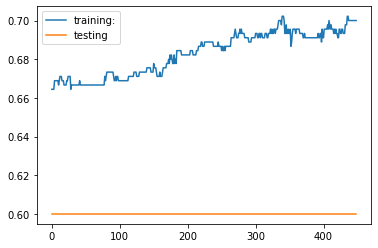

In [189]:
logit_reg_PCA(obs_feel_dfTrain, obs_feel_dfTest)

In [190]:
obs_feelNB = naive_bayes(obs_feel_dfTrain, obs_feel_dfTest)

training error: 0.9711111111111111
testing error: 0.58


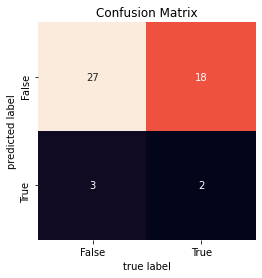

In [191]:
obs_feel_NNeval = NeuralNet(obs_feel_dfTrain, obs_feel_dfTest)

In [192]:
print(obs_feel_NNeval)

          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
False           0.42  0.5        0.6                0.6     0.9
True            0.42  0.5        0.4                0.4     0.1


In [193]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Observant and Feeling vs Else', 'TestError': 1-obs_feelNB[1]}, ignore_index = True)
obs_feel_avNN_err = (obs_feel_NNeval['Error_Rate'][0] + obs_feel_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Observant and Feeling vs Else', 'TestError': obs_feel_avNN_err}, ignore_index = True)

## Observant and Thinking (ST)
using the full dataset

In [194]:
ST_df500 = ST_df.sample(500)

In [195]:
obs_thi_dfTrain, obs_thi_dfTest = lucem_illud.trainTestSplit(ST_df500, holdBackFraction =0.1)

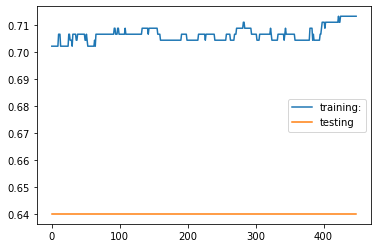

In [196]:
logit_reg_PCA(obs_thi_dfTrain, obs_thi_dfTest)

In [197]:
obs_thiNB = naive_bayes(obs_thi_dfTrain, obs_thi_dfTest)

training error: 0.9577777777777777
testing error: 0.66


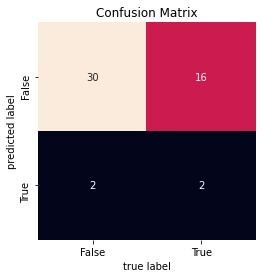

In [198]:
obs_thi_NNeval = NeuralNet(obs_thi_dfTrain, obs_thi_dfTest)

In [199]:
print(obs_thi_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.36  0.524306   0.652174           0.651413  0.937500
True            0.36  0.524306   0.500000           0.375556  0.111111


In [200]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Observant and Thinking vs Else', 'TestError': 1-obs_thiNB[1]}, ignore_index = True)
obs_thi_avNN_err = (obs_thi_NNeval['Error_Rate'][0] + obs_thi_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Observant and Thinking vs Else', 'TestError': obs_thi_avNN_err}, ignore_index = True)

## Intuitive and Judging (NJ)
using the full dataset

In [201]:
NJ_df500 = NJ_df.sample(500)

In [202]:
int_judg_dfTrain, int_judg_dfTest = lucem_illud.trainTestSplit(NJ_df500, holdBackFraction =0.1)

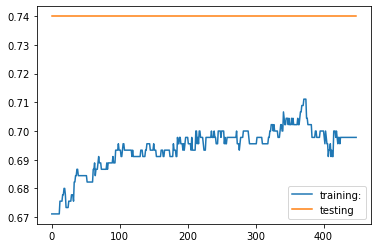

In [203]:
logit_reg_PCA(int_judg_dfTrain, int_judg_dfTest)

In [204]:
int_judgNB = naive_bayes(int_judg_dfTrain, int_judg_dfTest)

training error: 0.9711111111111111
testing error: 0.7


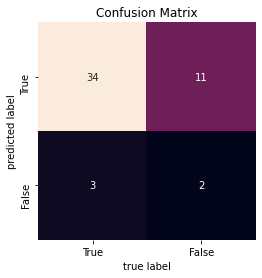

In [205]:
int_judg_NNeval = NeuralNet(int_judg_dfTrain, int_judg_dfTest)

In [206]:
print(int_judg_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.28  0.536383   0.755556           0.754294  0.918919
True            0.28  0.536383   0.400000           0.281538  0.153846


In [207]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Intuitive and Judging vs Else', 'TestError': 1-int_judgNB[1]}, ignore_index = True)
int_judg_avNN_err = (int_judg_NNeval['Error_Rate'][0] + int_judg_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Intuitive and Judging vs Else', 'TestError': int_judg_avNN_err}, ignore_index = True)

## Intuitive and Prospecting (NP)
using the full dataset

In [214]:
NP_df500 = NP_df.sample(500)

In [215]:
int_pro_dfTrain, int_pro_dfTest = lucem_illud.trainTestSplit(NP_df500, holdBackFraction =0.1)

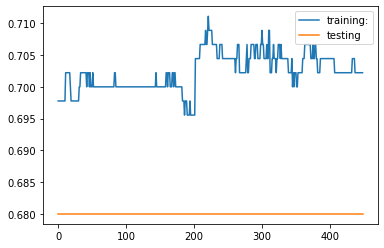

In [216]:
logit_reg_PCA(int_pro_dfTrain, int_pro_dfTest)

In [217]:
int_prospNB= naive_bayes(int_pro_dfTrain, int_pro_dfTest)

training error: 0.9777777777777777
testing error: 0.7


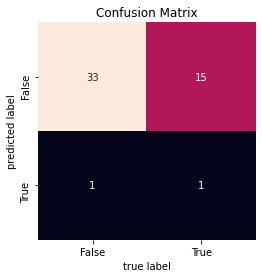

In [218]:
int_pro_NNeval = NeuralNet(int_pro_dfTrain, int_pro_dfTest)

In [219]:
print(int_pro_NNeval)

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
False           0.32  0.516544     0.6875           0.687279  0.970588
True            0.32  0.516544     0.5000           0.331250  0.062500


In [220]:
results_df = results_df.append({'Model': 'Naive Bayes', 'Data': 'Full Set Intuitive and Prospecting vs Else', 'TestError': 1-int_prospNB[1]}, ignore_index = True)
int_pro_avNN_err = (int_pro_NNeval['Error_Rate'][0] + int_pro_NNeval['Error_Rate'][1])/2
results_df = results_df.append({'Model': 'NN', 'Data': 'Full Set Intuitive and Prospecting vs Else', 'TestError': int_pro_avNN_err}, ignore_index = True)

## now let's look at the dataframe for the error results:

In [222]:
results_df.to_csv('Data/error_results.csv')

In [223]:
results_df.sort_values('TestError')

,Model,Data,TestError
30,NN,SubSet Analyst vs Explorer,0.142857
0,Naive Bayes,Full Set Intro vs Extraverts,0.180000
29,Naive Bayes,SubSet Analyst vs Explorer,0.214286
27,Naive Bayes,SubSet Analyst vs Sentinel,0.220000
20,NN,SubSet Intuitive vs Observant,0.230000
19,Naive Bayes,SubSet Intuitive vs Observant,0.230000
31,Naive Bayes,SubSet Diplomat vs Sentinel,0.260000
32,NN,SubSet Diplomat vs Sentinel,0.270000
28,NN,SubSet Analyst vs Sentinel,0.270000
40,NN,Full Set Intuitive and Judging vs Else,0.280000
